#### **Import Data**

In [2]:
# Import libraries
import os
import glob
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer


csv_files = glob.glob('../*/*.csv')

#### **Setup**

In [4]:
import json
import logging

import azureml.core
import pandas as pd
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig

In [5]:
print("Azure ML SDK version", azureml.core.VERSION)

Azure ML SDK version 1.39.0


In [6]:
ws = Workspace.from_config()

In [7]:
experiment_name = "automl-weather-forecasting"

experiment = Experiment(ws, experiment_name)

output = {}
output["Subscription ID"] = ws.subscription_id
output["Workspace"] = ws.name
output["SKU"] = ws.sku
output["Resource Group"] = ws.resource_group
output["Location"] = ws.location
output["Run History Name"] = experiment_name
pd.set_option("display.max_colwidth", None)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Subscription ID,8791d321-d956-4566-8a38-238c7aab2ebd
Workspace,ml-study-tien
SKU,Basic
Resource Group,ml-study
Location,eastus2
Run History Name,automl-weather-forecasting


#### **Compute**

In [8]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Azure ML compute cluster name
amlcompute_cluster_name = 'weather-cluster'

try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print("Found existing compute cluster.")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_DS3_v2", max_nodes=6
    )
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing compute cluster.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


#### **Data Configuration**

In [9]:
from datetime import datetime as dt

sub = 'cleaned'

time_column_name = 'dt'
custom_date_parser = lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S %Z")

df = pd.read_csv([s for s in csv_files if sub in s][0], parse_dates=[time_column_name])
df = df.drop(columns=['Day sin', 'Day cos', 'Year sin', 'Year cos'])
df.head(5)

,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,clouds_all,weather_main,wind_x,wind_y
0,978307200,21.87,25.26,21.40,23.09,1011,96,1.28,20,Mist,1.150456,0.561115
1,978310800,22.83,25.72,22.18,23.00,1012,83,1.00,20,Mist,0.984808,-0.173648
2,978314400,26.13,29.56,26.00,26.49,1012,73,1.00,20,Clouds,0.984808,0.173648
3,978318000,26.96,29.98,26.60,27.10,1012,66,1.00,20,Clouds,0.984808,0.173648
4,978321600,27.57,30.91,26.84,28.00,1011,65,0.78,20,Clouds,0.765669,-0.148831


In [10]:
df.drop_duplicates(subset='dt', keep='first', inplace=True)
df['dt'] = df['dt'].apply(lambda x: dt.fromtimestamp(int(x)))
df.drop(columns=['temp_max', 'temp_min', 'weather_main'], inplace=True)

In [12]:
n_test_periods = 200

def split_data_by_series(df, n):
    
    n = n * 7 * 24 # Weekly -> Daily -> Hourly
    df_head = df.apply(lambda dfg: dfg.iloc[:-n])
    df_tail = df.apply(lambda dfg: dfg.iloc[-n:])

    return df_head, df_tail

train, test = split_data_by_series(df, n_test_periods)

#### **Upload dataset to datastore**

In [13]:
from azureml.data.dataset_factory import TabularDatasetFactory

datastore = ws.get_default_datastore()
train_dataset = TabularDatasetFactory.register_pandas_dataframe(
    train, target=(datastore, "dataset/"), name="weather_train"
)
test_dataset = TabularDatasetFactory.register_pandas_dataframe(
    test, target=(datastore, "dataset/"), name="weather_test"
)

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//576d90ec-b2ea-48e8-8497-b2b8ec91441f/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//bf1b1aa4-c41f-4929-a9fb-7a1024477ca0/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


In [14]:
train_dataset.to_pandas_dataframe().tail()

,dt,temp,feels_like,pressure,humidity,wind_speed,clouds_all,wind_x,wind_y
145819,2017-08-21 02:00:00,25.21,30.78,1007,94,0.5,40,0.50,0.000000
145820,2017-08-21 03:00:00,25.19,29.63,1007,94,2.1,40,-1.05,-1.818653
145821,2017-08-21 04:00:00,25.20,30.41,1007,94,1.0,40,1.00,0.000000
145822,2017-08-21 05:00:00,25.29,30.56,1007,94,1.0,40,1.00,0.000000
145823,2017-08-21 06:00:00,25.20,30.06,1007,94,1.5,40,-0.75,-1.299038


#### **Modeling**

In [27]:
target_column_name = 'temp'

In [26]:
featurization_config = FeaturizationConfig()
# Force the pressure feature to be numeric type.
# Fill missing values in the target column, temp, with zeros.
featurization_config.add_transformer_params(
    "Imputer", ["temp"], {"strategy": "constant", "fill_value": 0}
)
featurization_config.add_transformer_params(
    "Imputer", ["pressure"], {"strategy": "median"}
)
featurization_config.add_transformer_params(
    "Imputer", ["humidity"], {"strategy": "median"}
)
featurization_config.add_transformer_params(
    "Imputer", ["clouds_all"], {"strategy": "mode"}
)

#### **Train**

In [29]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters

forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=n_test_periods,
    freq="H",  # Set the forecast frequency to be hourly
)

automl_config = AutoMLConfig(
    task="forecasting",
    enable_dnn=True,
    debug_log="automl_weather_forecast.log",
    primary_metric="normalized_mean_absolute_error",
    experiment_timeout_minutes=60,
    training_data=train_dataset,
    label_column_name=target_column_name,
    compute_target=compute_target,
    enable_early_stopping=True,
    featurization=featurization_config,
    n_cross_validations=5,
    verbosity=logging.INFO,
    blocked_models=['ExponentialSmoothing'],
    max_concurrent_iterations=6,
    max_cores_per_iteration=-1,
    forecasting_parameters=forecasting_parameters,
)

In [30]:
remote_run = experiment.submit(automl_config, show_output=True)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-weather-forecasting,AutoML_55108467-65f3-47e7-b43d-5b6545c4dc52,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [31]:
remote_run.wait_for_completion()

{'runId': 'AutoML_55108467-65f3-47e7-b43d-5b6545c4dc52',
 'target': 'weather-cluster',
 'status': 'Completed',
 'startTimeUtc': '2022-03-31T12:21:48.791883Z',
 'endTimeUtc': '2022-03-31T13:33:27.137382Z',
 'services': {},
 'warnings': [{'source': 'JasmineService',
   'message': 'Experiment timeout reached, hence experiment stopped. Current experiment timeout: 1 hour(s) 0 minute(s)'}],
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_mean_absolute_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'weather-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-weather-forecasting","subscription_id":"8791d321-d956-4566-8a38-238c7aab2ebd","resource_group":"ml-study","workspace_name":"ml-study-tien","region":"eastus2","compute_target":"weather-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_b

In [32]:
from azureml.widgets import RunDetails

RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

#### **Retrieve the best run results**

In [39]:
best_run = remote_run.get_best_child()
model_name = best_run.properties["model_name"]
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-weather-forecasting,AutoML_55108467-65f3-47e7-b43d-5b6545c4dc52_506,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [41]:
best_run.get_metrics()

{'r2_score': 0.9986253789410344,
 'normalized_root_mean_squared_error': 0.003824068056645326,
 'normalized_mean_absolute_error': 0.003082616546465208,
 'normalized_median_absolute_error': 0.0028609368642841387,
 'mean_absolute_percentage_error': 0.222209069299655,
 'root_mean_squared_log_error': 0.0026467057698993162,
 'explained_variance': 0.9986263778308933,
 'mean_absolute_error': 0.06152902626744554,
 'spearman_correlation': 0.9980581484956941,
 'normalized_root_mean_squared_log_error': 0.0036192416036144362,
 'root_mean_squared_error': 0.07632839841064068,
 'median_absolute_error': 0.057104299811111404,
 'predicted_true': 'aml://artifactId/ExperimentRun/dcid.AutoML_55108467-65f3-47e7-b43d-5b6545c4dc52_506/predicted_true',
 'residuals': 'aml://artifactId/ExperimentRun/dcid.AutoML_55108467-65f3-47e7-b43d-5b6545c4dc52_506/residuals',
 'forecast_train_table': 'aml://artifactId/ExperimentRun/dcid.AutoML_55108467-65f3-47e7-b43d-5b6545c4dc52_506/forecast_train_table',
 'forecast_validate

#### **Featurization summary**

In [42]:
best_run.download_file("outputs/featurization_summary.json", "featurization_summary.json")

with open("featurization_summary.json", "r") as f:
    records = json.load(f)

fs = pd.DataFrame.from_records(records)
fs[["RawFeatureName", "TypeDetected", "Dropped", "EngineeredFeatureCount", "Transformations",]]

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,feels_like,Numeric,No,2,"[MedianImputer, ImputationMarker]"
1,pressure,Numeric,No,2,"[MedianImputer, ImputationMarker]"
2,humidity,Numeric,No,2,"[MedianImputer, ImputationMarker]"
3,wind_speed,Numeric,No,2,"[MedianImputer, ImputationMarker]"
4,clouds_all,Numeric,No,2,"[MedianImputer, ImputationMarker]"
5,wind_x,Numeric,No,2,"[MedianImputer, ImputationMarker]"
6,wind_y,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,_automl_target_col,Numeric,No,1,[ImputationMarker]
8,dt,DateTime,No,11,[DateTimeTransformer]


#### **Inference**

Evaluate the model's performance on the test dataset by using batch inference.

In [43]:
test_experiment = Experiment(ws, experiment_name + "_inference")

#### **Retrieve forecast results**

In [65]:
from run_forecast import run_remote_inference

remote_run_infe = run_remote_inference(
    test_experiment=test_experiment,
    compute_target=compute_target,
    train_run=best_run,
    test_dataset=test_dataset,
    target_column_name=target_column_name,
)

remote_run_infe.wait_for_completion(show_output=False)

# Download the forecasted results to the local folders
remote_run_infe.download_file("outputs/predictions.csv", "../data/predictions.csv")

#### **Evaluate**

In [66]:
# load forecast data frame
fc_df = pd.read_csv("../data/predictions.csv", parse_dates=[time_column_name])
fc_df.head()

,dt,feels_like,pressure,humidity,wind_speed,clouds_all,wind_x,wind_y,temp,prediction_interval,predicted
0,2017-08-21 07:00:00,31.13,1007,88,1.0,20,1.000000,0.000000,26.06,"[25.896960684385622, 26.196208543364197]",26.046585
1,2017-08-21 08:00:00,31.19,1008,83,2.1,40,0.364661,-2.068096,26.95,"[26.73219477573706, 27.155395156415675]",26.943795
2,2017-08-21 09:00:00,33.81,1008,79,2.6,40,-0.451485,-2.560500,29.14,"[28.869668077381245, 29.387980573188347]",29.128824
3,2017-08-21 10:00:00,33.03,1008,66,4.1,40,1.402283,-3.852740,30.45,"[30.100407287744535, 30.69890300570169]",30.399655
4,2017-08-21 11:00:00,32.70,1008,62,4.6,40,1.573293,-4.322586,30.84,"[30.389603390966144, 31.058741945763515]",30.724173


[Test data scores]

explained_variance: 0.999
normalized_root_mean_squared_log_error: 0.005
root_mean_squared_log_error: 0.004
normalized_mean_absolute_error: 0.004
normalized_root_mean_squared_error: 0.005
r2_score: 0.999
spearman_correlation: 0.999
normalized_median_absolute_error: 0.003
median_absolute_error: 0.054
mean_absolute_percentage_error: 0.248
mean_absolute_error: 0.069
root_mean_squared_error: 0.098


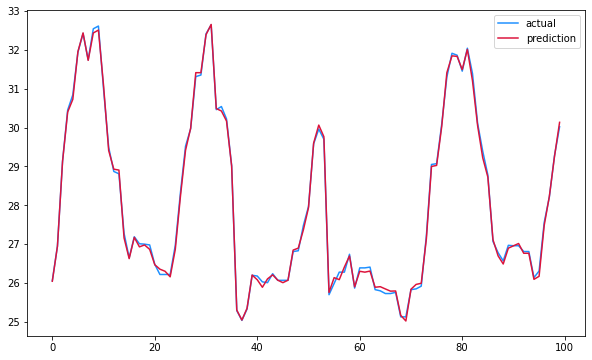

In [67]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module
scores = scoring.score_regression(
    y_test=fc_df[target_column_name],
    y_pred=fc_df["predicted"],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET),
)

print("[Test data scores]\n")
for key, value in scores.items():
    print("{}: {:.3f}".format(key, value))

# Plot outputs
%matplotlib inline
plt.figure(figsize=(10,6))
fc_df['temp'][:100].plot(label='actual', color='dodgerblue', linewidth=1.5)
fc_df['predicted'][:100].plot(label='prediction', color='crimson', linewidth=1.5)
plt.legend()

**Larger periods**

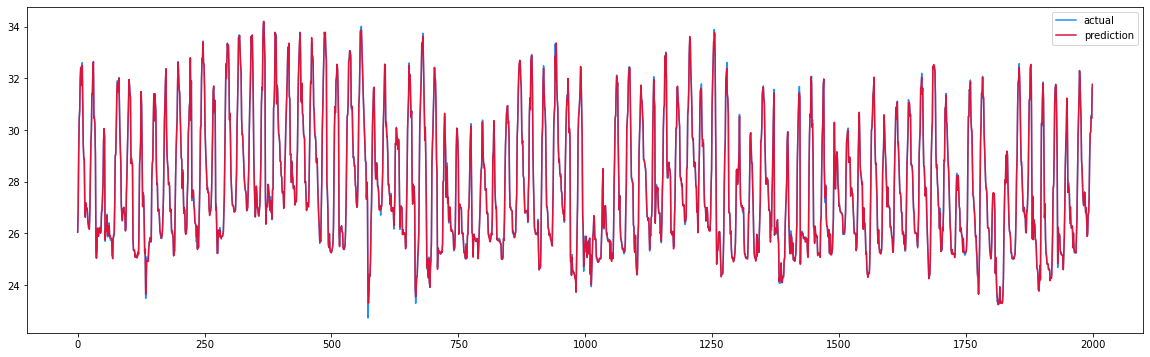

In [71]:
plt.figure(figsize=(20,6))
fc_df['temp'][:2000].plot(label='actual', color='dodgerblue', linewidth=1.5)
fc_df['predicted'][:2000].plot(label='prediction', color='crimson', linewidth=1.5)
plt.legend()

#### **Register Model**

In [73]:
description = "AutoML Weather Forecaster"
tags = {"forecast": "", "weather": "", "timeseries": ""}
model = remote_run.register_model(
    model_name=model_name, description=description, tags=tags
)

print(remote_run.model_id)

AutoML551084676506


#### **Scoring script**

In [74]:
script_file_name = "score_fcast.py"
best_run.download_file("outputs/scoring_file_v_1_0_0.py", script_file_name)

#### **Deploy the model as a Web Service on Azure Container Instance**

In [75]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(
    environment=best_run.get_environment(), entry_script=script_file_name
)

aciconfig = AciWebservice.deploy_configuration(
    cpu_cores=2,
    memory_gb=4,
    tags={"type": "automl-forecasting"},
    description="AutoML Weather forecasting service",
)

aci_service_name = "automl-weather-forecast"
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-weather-forecast
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-03-31 20:53:07+07:00 Creating Container Registry if not exists.
2022-03-31 20:53:07+07:00 Registering the environment.
2022-03-31 20:53:08+07:00 Use the existing image.
2022-03-31 20:53:08+07:00 Generating deployment configuration.
2022-03-31 20:53:08+07:00 Submitting deployment to compute.
2022-03-31 20:53:14+07:00 Checking the status of deployment automl-weather-forecast..
2022-03-31 20:58:59+07:00 Checking the status of inference endpoint automl-weather-forecast.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [76]:
aci_service.get_logs()

'2022-03-31T13:58:42,612293500+00:00 - gunicorn/run \nDynamic Python package installation is disabled.\nStarting HTTP server\n2022-03-31T13:58:42,620022000+00:00 - iot-server/run \n2022-03-31T13:58:42,621848000+00:00 - rsyslog/run \n2022-03-31T13:58:42,629517400+00:00 - nginx/run \nrsyslogd: /azureml-envs/azureml_d9e3d76962d7db86fba419399940e31f/lib/libuuid.so.1: no version information available (required by rsyslogd)\nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2022-03-31T13:58:42,820229400+00:00 - iot-server/finish 1 0\n2022-03-31T13:58:42,821885800+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 20.1.0\nListening at: http://127.0.0.1:31311 (112)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 139\nSPARK_HOME not set. Skipping PySpark Initialization.\nInitializing logger\n2022-03-31 13:58:44,440 | root | INFO | Starting up app insights client\nlogging socket was found. logging is available.\nlogg

#### **Call the service**

In [77]:
import json

X_query = test.copy()
X_query.pop(target_column_name)
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
sample_quantiles = [0.025, 0.975]
test_sample = json.dumps(
    {"data": X_query.to_dict(orient="records"), "quantiles": sample_quantiles}
)
response = aci_service.run(input_data=test_sample)
# translate from networkese to datascientese
try:
    res_dict = json.loads(response)
    y_fc_all = pd.DataFrame(res_dict["index"])
    y_fc_all[time_column_name] = pd.to_datetime(
        y_fc_all[time_column_name], unit="ms"
    )
    y_fc_all["forecast"] = res_dict["forecast"]
    y_fc_all["prediction_interval"] = res_dict["prediction_interval"]
except:
    print(res_dict)

In [78]:
y_fc_all.head()

,dt,forecast,prediction_interval
0,2017-08-21 07:00:00,26.046585,"[25.896960684385622, 26.196208543364197]"
1,2017-08-21 08:00:00,26.943795,"[26.73219477573706, 27.155395156415675]"
2,2017-08-21 09:00:00,29.128824,"[28.869668077381245, 29.387980573188347]"
3,2017-08-21 10:00:00,30.399655,"[30.100407287744535, 30.69890300570169]"
4,2017-08-21 11:00:00,30.724173,"[30.389603390966144, 31.058741945763515]"


In [79]:
# Check the accuracy prediction of the first rows
test[test['dt'] == '2017-08-21 07:00:00']

,dt,temp,feels_like,pressure,humidity,wind_speed,clouds_all,wind_x,wind_y
147617,2017-08-21 07:00:00,26.06,31.13,1007,88,1.0,20,1.0,0.0


#### **Delete service option**

In [ ]:
# serv = Webservice(ws, "automl-weather-forecast")
# serv.delete()  # don't do it accidentally